# SYDE 556/750 --- Assignment 4
**Student ID: 20814292**

*Note:* Please include your numerical student ID only, do *not* include your name.

*Note:* Refer to the [PDF](https://github.com/celiasmith/syde556-f22/raw/master/assignments/assignment_04/syde556_assignment_04.pdf) for the full instructions (including some hints), this notebook contains abbreviated instructions only. Cells you need to fill out are marked with a "writing hand" symbol. Of course, you can add new cells in between the instructions, but please leave the instructions intact to facilitate marking.

In [ ]:
# Import numpy and matplotlib
import numpy as np
import matplotlib.pyplot as plt

# Import nengo and some helper functions for Q1
import nengo
from nengo.utils.ensemble import tuning_curves
from nengo.utils.connection import eval_point_decoding
from nengo import Lowpass

# Fix the numpy random seed for reproducible results
np.random.seed(18945)

# Some formating options
%config InlineBackend.figure_formats = ['svg']

# 1. Building an ensemble of neurons

In [ ]:
tau_RC = 20 / 1000
tau_ref = 2 / 1000
sigma = 0.1 * 200

def question_1(_radius=1.0, _seed=42, _tau_RC=tau_RC, _tau_ref=tau_ref, show_plot=False):
    model = nengo.Network(seed=_seed)
    with model:
        ensemble = nengo.Ensemble(
            100,
            radius=_radius,
            dimensions=1,
            intercepts=nengo.dists.Uniform(-1.0, 1.0),
            max_rates=nengo.dists.Uniform(100, 200),  
            neuron_type=nengo.LIF(tau_rc=_tau_RC, tau_ref=_tau_ref),
        )

        conn = nengo.Connection(ensemble, ensemble)

    # Build and simulate the model to get tuning curves and decoders
    with nengo.Simulator(model) as sim:
        # Compute decoders under noise
        x, activities = nengo.utils.ensemble.tuning_curves(ensemble, sim)
        
        _, _, x_hat = eval_point_decoding(
            conn, sim, x,
        )

    # Compute representation error and RMSE
    error = x.flatten() - x_hat.flatten()
    rmse = np.sqrt(np.mean(error**2))

    if show_plot:
        # Plot tuning curves
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.title(f"Tuning Curves ($r$={_radius}," + r"$\tau_{RC}$" + f"={_tau_RC:.3f},"+r"$\tau_{ref}$"+f"={_tau_ref:.3f})")
        plt.xlabel("Input ($x$)")
        plt.ylabel("Neural Activity (Hz)")
        plt.plot(x, activities)
        plt.grid()

        # Plot representation accuracy
        plt.subplot(1, 2, 2)
        plt.title(f"Representation Error (RMSE = {rmse:.4f})")
        plt.xlabel("Input ($x$)")
        plt.ylabel("$\hat{x} - x$")
        plt.plot(x, error)
        plt.grid()

        plt.tight_layout()
        plt.show()

    return rmse

**a) Tuning curves.** Plot the population tuning curves. Plot the representation accuracy plot ($x - \hat{x}$). Compute and report the RMSE.

In [ ]:
rmse = question_1(show_plot=True)

#### Question 1a: Reporting the RMSE
RMSE = 0.003885101177305886

**b) RMSE and radius.** Compute the RMSE for (at least) the four different radii $0.5$, $1$, $2$, and $4$. Plot your results. Compute the RMSE for (at least) the four different radii $0.5$, $1$, $2$, and $4$. Plot your results. Make sure your neurons have the same (relative, i.e., scaled by the radius) $x$-intercepts and maximum rates across all experiments.

In [ ]:
radiuses = [0.5, 1, 2, 4, 8, 16]
rmses = []
for i, current_radius in enumerate(radiuses):
    rmse = question_1(_radius=current_radius)
    rmses.append(rmse)

coeffs = np.polyfit(radiuses, rmses, deg=1)  # Linear fit
best_fit_line = np.polyval(coeffs, radiuses)

# Plot RMSEs vs Radiuses with best fit line
plt.figure(figsize=(8, 5))
plt.plot(radiuses, rmses, marker='o', color='blue', label='RMSE vs Radius')  # Data points
plt.plot(radiuses, best_fit_line, linestyle='--', color='red', label='Best Fit Line')  # Fit line
plt.title(f"RMSE vs Radius (Best Fit Line: Slope = {coeffs[0]:.4f}, Intercept = {coeffs[1]:.3f})")
plt.xlabel("Radius")
plt.ylabel("RMSE")
plt.grid(True)
plt.legend()
plt.show()

**c) Discussion.** What mathematical relationship between the radius and the RMSE do you observe (write down an equation)? Explain why this is the case.

I observed a linear relationship between the radius and the RMSE, which can be described by the following equation:

**RMSE** = 3.88510118e-03 $\times$ **radius** + 4.22633436e-18

This relationship exists because the decoders are being computed under the assumption of noise. Increase in the radius of the ensemble results in the magnitude of the decoder coefficients increase, which leads to an increase in regulartization error term, $E_{noise}$:
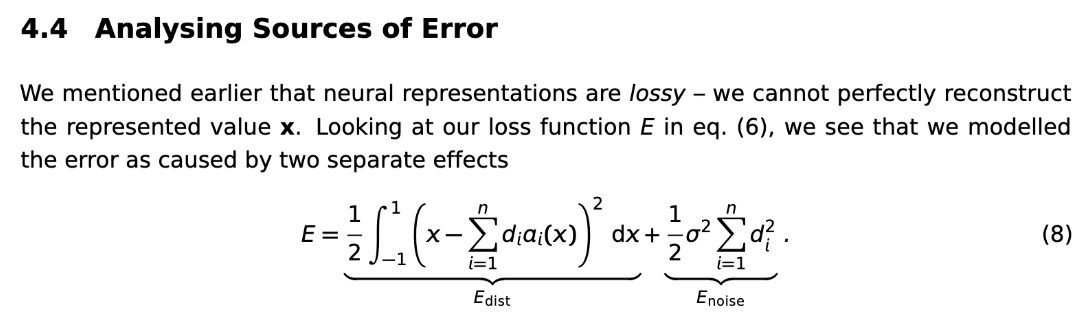

**d) RMSE and refractory period.** What happens to the RMSE and the tuning curves as $\tau_\mathrm{ref}$ changes between $1$ and $5\,\mathrm{ms}$? Plot the tuning curves for at least four different $\tau_\mathrm{ref}$ and produce a plot showing the RMSE over $\tau_\mathrm{ref}$. Again, make sure to use the same neuron ensemble parameters in all your trials.

In [ ]:
tau_refs = np.linspace(1, 5, 5) / 1000
rmses = []
for i, current_tau_ref in enumerate(tau_refs):
    rmse = question_1(_tau_ref=current_tau_ref, show_plot=True)
    rmses.append(rmse)

plt.figure(figsize=(8, 5))
plt.plot(tau_refs, rmses)  # Data points
plt.title(r"RMSE vs $\tau_{ref}$")
plt.xlabel(r"$\tau_{ref}$")
plt.ylabel("RMSE")
plt.grid(True)
plt.show()

The RMSE increases (exponentially) as $\tau_{ref}$ increases between 1 ms to 5 ms. As $\tau_{ref}$ increases between 1 ms to 5 ms, the curvature of the tuning curves also increases.

**e) RMSE and membrane time constant.** What happens to the RMSE and the tuning curves as $\tau_\mathrm{RC}$ changes between $10$ and $100\,\mathrm{ms}$? Plot the tuning curves for at least four different $\tau_\mathrm{RC}$ and produce a plot showing the RMSE over $\tau_\mathrm{RC}$.  Again, make sure to use the same neuron ensemble parameters in all your trials.

In [ ]:
tau_RCs = np.linspace(10, 100, 5) / 1000
rmses = []
for i, current_tau_RC in enumerate(tau_RCs):
    rmse = question_1(_tau_RC=current_tau_RC, show_plot=True)
    rmses.append(rmse)

# Plot RMSEs vs tau_RCs with best fit line
plt.figure(figsize=(8, 5))
plt.plot(tau_RCs, rmses)  # Data points
plt.title(r"RMSE vs $\tau_{RC}$")
plt.xlabel(r"$\tau_{RC}$")
plt.ylabel("RMSE")
plt.grid(True)
plt.legend()
plt.show()

The RMSE decreases (exponentially) as $\tau_{RC}$ increases between 10 ms to 100 ms. As $\tau_{RC}$ increases between 10 ms to 100 ms, the curvature of the tuning curves also decreases.

**f) Discussion.** Discuss the last two results. Describe what happens to the tuning curves as $\tau_\mathrm{ref}$ and $\tau_\mathrm{RC}$ change (you do not need to come up with a mathematical relationship here). Explain why the change in tuning curve shape influences the RMSE in the way you observe.

As $\tau_{ref}$ increases between 1 ms to 5 ms, the curvature of the tuning curves increases.
As $\tau_{RC}$ increases between 10 ms to 100 ms, the curvature of the tuning curves decreases.
As the curvature of the tuning curves increase, the RMSE would also increase. This is because there is no way to perfectly decode a linear function from non-linear tuning curves. As the curvature of the tuning curves increases, this causes the tuning-curves to become more non-linear, resulting in a higher amount of static distortion ($E_{dist}$) when performing the linear decoding, which increases the RMSE.
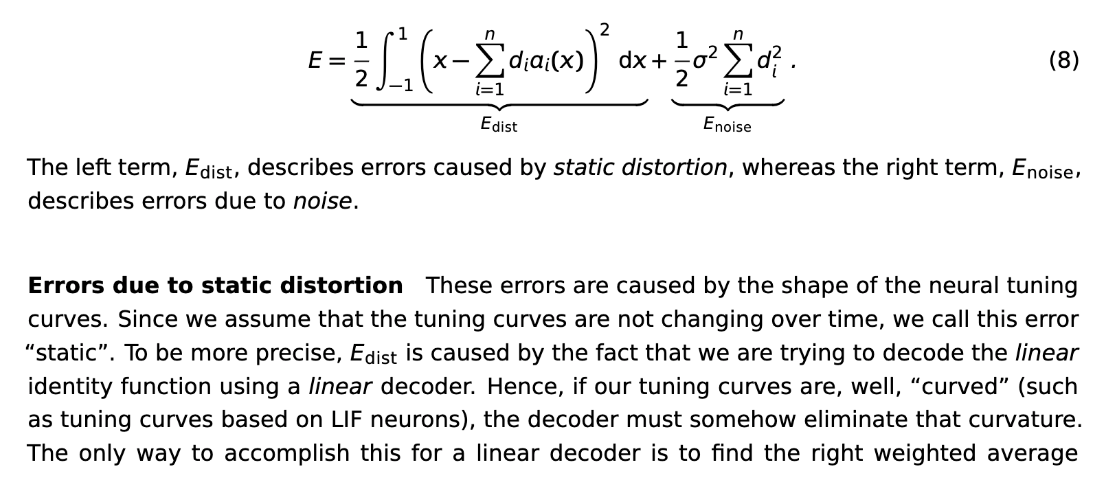

# 2. Connecting neurons

In [ ]:
probe_synapse = 10 / 1000

def question_2(
        f=lambda x: x, 
        node_input_f=lambda t: 0.0 if t < 0.1 else (1.0 if (t >= 0.1 and t <= 0.4) else 0.0), 
        _radius=1.0, 
        _seed=42, 
        _tau_RC=tau_RC, 
        _tau_ref=tau_ref
    ):
    model = nengo.Network(seed=_seed)
    with model:
        node_input = nengo.Node(node_input_f)
        ensemble_1 = nengo.Ensemble(
            100,
            radius=_radius,
            dimensions=1,
            intercepts=nengo.dists.Uniform(-1.0, 1.0),
            max_rates=nengo.dists.Uniform(100, 200),  
            neuron_type=nengo.LIF(tau_rc=_tau_RC, tau_ref=_tau_ref),
        )

        ensemble_2 = nengo.Ensemble(
            50,
            radius=_radius,
            dimensions=1,
            intercepts=nengo.dists.Uniform(-1.0, 1.0),
            max_rates=nengo.dists.Uniform(100, 200),  
            neuron_type=nengo.LIF(tau_rc=_tau_RC, tau_ref=_tau_ref),
        )
        nengo.Connection(node_input, ensemble_1)
        nengo.Connection(ensemble_1, ensemble_2, synapse=Lowpass(10/1000), function=f)

        node_input_probe = nengo.Probe(node_input)
        ensemble_1_probe = nengo.Probe(ensemble_1, synapse=probe_synapse)
        ensemble_2_probe = nengo.Probe(ensemble_2, synapse=probe_synapse)


    # Build and simulate the model to get tuning curves and decoders
    with nengo.Simulator(model) as sim:
        sim.run(0.5)

    # Plot the decoded output of the ensemble
    plt.figure()
    plt.plot(sim.trange(), sim.data[node_input_probe], label="Input")
    plt.plot(sim.trange(), sim.data[ensemble_1_probe], label="Ensemble 1")
    plt.plot(sim.trange(), sim.data[ensemble_2_probe], label="Ensemble 2")
    plt.xlim(0, 0.5)
    plt.xlabel("Time (s)")
    plt.ylabel("Represented Value")
    plt.legend()

**a) Computing the identity function.** Show the input value and the decoded values from the two  ensembles in three separate plots. Run the simulation for $0.5\,\mathrm{s}$.

In [ ]:
question_2()

**b) Computing an affine transformation.** Make a new version of the model where instead of computing the identity function, it computes $y(t) = 1 - 2x(t)$. Show the same graphs as in part (a).

In [ ]:
question_2(f=lambda x: 1 - 2*x)

# 3. Dynamics

In [ ]:
tau_recurrent = 50 / 1000
def question_3(
        f=lambda x: tau_recurrent * x[0] + x[1], 
        node_input_f=lambda t: 0.9 if (t >= 0.04 and t < 1.0) else 0.0,
        neuron_type=nengo.LIF,
        _radius=1.0, 
        _seed=42, 
        _tau_RC=tau_RC, 
        _tau_ref=tau_ref,
        _tau_recurrent=tau_recurrent,
    ):
    model = nengo.Network(seed=_seed)
    with model:
        node_input = nengo.Node(node_input_f)
        ensemble_1 = nengo.Ensemble(
            200,
            radius=_radius,
            dimensions=2,
            intercepts=nengo.dists.Uniform(-1.0, 1.0),
            max_rates=nengo.dists.Uniform(100, 200),  
            neuron_type=neuron_type(tau_rc=_tau_RC, tau_ref=_tau_ref)
        )
        
        nengo.Connection(node_input, ensemble_1[0], synapse=Lowpass(5/1000))
        nengo.Connection(ensemble_1, ensemble_1[1], synapse=Lowpass(_tau_recurrent), function=f)

        node_input_probe = nengo.Probe(node_input)
        ensemble_1_input_probe = nengo.Probe(ensemble_1[0], synapse=probe_synapse)
        ensemble_1_state_probe = nengo.Probe(ensemble_1[1], synapse=probe_synapse)



    # Build and simulate the model to get tuning curves and decoders
    with nengo.Simulator(model) as sim:
        sim.run(1.5)

    # Compute the ideal integral using np.cumsum
    dt = sim.dt
    input_signal = sim.data[node_input_probe]
    ideal_integral = np.cumsum(input_signal) * dt

    # Plot the decoded output of the ensemble
    plt.figure(figsize=(10, 6))
    plt.plot(sim.trange(), sim.data[node_input_probe], label="Input")
    plt.plot(sim.trange(), sim.data[ensemble_1_input_probe], label="Ensemble 1 Input")
    plt.plot(sim.trange(), sim.data[ensemble_1_state_probe], label="Ensemble 1 State (Simulated)")
    plt.plot(sim.trange(), ideal_integral, label="Ensemble 1 State (Ideal)", linestyle='--', color='red')
    plt.xlim(0, 1.5)
    plt.xlabel("Time (s)")
    plt.ylabel("Represented Value")
    plt.legend()
    plt.grid()
    plt.show()

**a) Transforming the dynamical system.** Rewrite the linear dynamical system describing the integrator in terms of $\frac{\mathrm{d}\vec x(t)}{\mathrm{d}t} = \mathbf{A} \mathbf{x} + \mathbf{B} \mathbf{u}$, i.e., write down the matrices $\mathbf{A}$ and $\mathbf{B}$ (you can just use the equations from class, you do not have to re-derive the equations) What are the matrices $\mathbf{A}'$ and $\mathbf{B}'$ we have to use when implementing this system using the recurrent connection post-synaptic filter?

$\mathbf{A} = \mathbf{0}_{d \times d}$

$\mathbf{B} = \mathbf{I}_{d \times d}$

$\mathbf{A'} = \tau\mathbf{A} + \mathbf{I} = \mathbf{I}_{d \times d}$

$\mathbf{B'} = \tau\mathbf{B} = \tau\mathbf{I}_{d \times d}$


**b) Integrator using spiking neurons.**  Show the input, the ideal integral, and the value represented by the ensemble when the input is a value of $0.9$ from $t=0.04$ to $t=1.0$ (and $0$ for other times). Run the simulation for $1.5\,\mathrm{s}$.

In [ ]:
question_3()

**c) Discussion.** What is the expected ideal result, i.e., if we just mathematically computed the integral of the input, what is the equation describing the integral? How does the simulated output compare to that ideal?

The input $u(t)$ is defined as:
\begin{align*}
u(t) =
\begin{cases} 
0.9 & \text{if } 0.04 \leq t \lt 1.0, \\
0 & \text{otherwise.}
\end{cases}
\end{align*}

The integral of $u(t)$ from $0$ to $t$ is:
\begin{align*}
\int_0^t u(t') \, dt' =
\begin{cases} 
0 & \text{if } t < 0.04, \\
0.9(t - 0.04) & \text{if } 0.04 \leq t \lt 1.0, \\
0.864 & \text{if } 1.0 \leq t.
\end{cases}
\end{align*}

Compared to the ideal, the simulated output is much more noisy. On top of that, the simulated output consistently has a lower value in the entire range of the simulation.

**d) Simulation using rate neurons.** Change the neural simulation to rate mode. Re-run the simulation in rate mode. Show the resulting plots.

In [ ]:
question_3(neuron_type=nengo.LIFRate)

**e) Discussion.** How does this compare to the result in part (b)? What deviations from the ideal do you still observe? Where do those deviations come from?

Comparing the simulated state from part (b) to part (d), using the LIFRate neuron type results in much less noise in the simulated state. The deviations from the ideal state still observed consistently would be the lower value of the simulated state. These deviations are caused by (at least) two kinds of error: static distortion and noise.

**f) Integration of a shorter input pulse.** Returning to spiking mode, change the input to be a value of $0.9$ from $t=0.04$ to $0.16$. Show the same plots as before (the input, the ideal, and the value represented by the ensemble over $1.5\,\mathrm{s}$).

In [ ]:
question_3(node_input_f=lambda t: 0.9 if (t >= 0.04 and t < 0.16) else 0.0)

**g) Discussion.** How does this compare to (b)? What is the ideal equation? Does it work as intended? If not, why is it better or worse?

Compared to (b), we see a similar effect: there is an increased amount of noise in the simulated state versus the ideal state with both the longer and the shorter pulse. We also see a consistent offset between the steady-state value ($t=[0.16, 1.5]$) of the the simulated state versus the ideal state. Here, the integrator does work in principle as intended as the simulated state does track the ideal state fairly well overall.

The input $u(t)$ is defined as:
\begin{align*}
u(t) =
\begin{cases} 
0.9 & \text{if } 0.04 \leq t \lt 0.16, \\
0 & \text{otherwise.}
\end{cases}
\end{align*}

The integral of $u(t)$ from $0$ to $t$ is:
\begin{align*}
\int_0^t u(t') \, dt' =
\begin{cases} 
0 & \text{if } t < 0.04, \\
0.9(t - 0.04) & \text{if } 0.04 \leq t \lt 0.16, \\
0.108 & \text{if } 0.16 \leq t.
\end{cases}
\end{align*}

**h) Input ramp.** Change the input to a ramp input from $0$ to $0.9$ from $t=0$ to $t=0.45$ (and $0$ for $t>0.45$). Show the same plots as in the previous parts of this question.

In [ ]:
question_3(node_input_f=lambda t: 2*t if (t >= 0 and t <= 0.45) else 0.0)

**i) Discussion.** What does the ensemble end up representing, and why? What is the (ideal) equation for the curve traced out by the ensemble?

The ensemble ends up representing a 2nd order polynomial function during the ramp phase, due to the fact that the function being integrated is a 1st order polynomial.

The input $u(t)$ is defined as:
\begin{align*}
u(t) =
\begin{cases} 
2t & \text{if } 0 \leq t \lt 0.45, \\
0 & \text{otherwise.}
\end{cases}
\end{align*}

The integral of $u(t)$ from $0$ to $t$ is:
\begin{align*}
\int_0^t u(t') \, dt' =
\begin{cases} 
t^2 & \text{if } 0 \leq t \lt 0.45, \\
0.2025 & \text{otherwise.}
\end{cases}
\end{align*}

**j) Sinusoidal input.** Change the input to $5\sin(5t)$. Show the same plots as before.

In [ ]:
question_3(node_input_f=lambda t: 5*np.sin(5*t))

**k) Discussion.** What should the value represented by the ensemble be? Write the equation. How well does it do? What are the differences between the model's behaviour and the expected ideal behaviour and why do these differences occur?

The input $u(t)$ is defined as:
\begin{align*}
u(t) =
\begin{cases} 
5\sin(5t) & \text{if } 0 \leq t \leq 1.5, \\
\end{cases}
\end{align*}

The integral of $u(t)$ from $0$ to $t$ is:
\begin{align*}
\int_0^t u(t') \, dt' =
\begin{cases} 
1 - \cos(5t) & \text{if } 0 \leq t \leq 1.5, \\
\end{cases}
\end{align*}

The simulated state does not do well at all at the representation of the ideal state. The main differences between the simulated state and the ideal state is the low dynamic range of the simulated state, which prevents the simulate state to accurately represent the ideal state. This difference occurs due to staturation of neurons to its maximum firing rate.

**l) Controlled integrator.** Implement a controlled integrator over two popoulations. Demonstrate that it's working as expected.

In [ ]:
def question_3l(
        node_input_f=lambda t: 0.9 if (t >= 0.04 and t < 1.0) else 0.0,
        control_f=lambda t: 1,
        neuron_type=nengo.LIF,
        _radius=1.0, 
        _seed=42, 
        _tau_RC=tau_RC, 
        _tau_ref=tau_ref,
        _tau_recurrent=tau_recurrent,
    ):
    model = nengo.Network(seed=_seed)
    with model:
        node_input = nengo.Node(node_input_f)
        control_input = nengo.Node(control_f)
        A = nengo.Ensemble(
            200,
            radius=_radius,
            dimensions=2,
            intercepts=nengo.dists.Uniform(-1.0, 1.0),
            max_rates=nengo.dists.Uniform(100, 200),  
            neuron_type=neuron_type(tau_rc=_tau_RC, tau_ref=_tau_ref)
        )
        
        nengo.Connection(node_input, A, synapse=Lowpass(5/1000), transform=[[_tau_recurrent], [0]])
        nengo.Connection(control_input, A[1])
        nengo.Connection(A, A[0], synapse=Lowpass(_tau_recurrent), function=lambda x: x[0] * x[1])

        node_input_probe = nengo.Probe(node_input)
        control_input_probe = nengo.Probe(control_input)
        A_state_probe = nengo.Probe(A[0], synapse=probe_synapse)


    # Build and simulate the model to get tuning curves and decoders
    with nengo.Simulator(model) as sim:
        sim.run(1.5)

    # Compute the ideal integral using np.cumsum
    dt = sim.dt
    input_signal = sim.data[node_input_probe]
    ideal_integral = np.cumsum(input_signal) * dt

    # Plot the decoded output of the ensemble
    plt.figure(figsize=(10, 6))
    plt.plot(sim.trange(), sim.data[node_input_probe], label="Input")
    plt.plot(sim.trange(), sim.data[control_input_probe], label="Control")
    plt.plot(sim.trange(), sim.data[A_state_probe], label="A State (Simulated)")
    plt.plot(sim.trange(), ideal_integral, label="Ensemble 1 State (Ideal)", linestyle='--', color='red')
    plt.xlim(0, 1.5)
    plt.xlabel("Time (s)")
    plt.ylabel("Represented Value")
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
question_3l()
question_3l(control_f=nengo.processes.Piecewise({0: 1, 0.6: 0.5}))
question_3l(node_input_f=lambda t: np.sin(5*t))
question_3l(node_input_f=lambda t: np.sin(5*t), control_f=nengo.processes.Piecewise({0: 1, 0.6: 0.5}))


**m) 🌟 Bonus question.** Implement a nonlinear dynamical system we have not seen in class (and that is not in the book). Demonstrate that it's working as expected

✍ \<YOUR SOLUTION HERE\>

In [ ]:
# ✍ <YOUR SOLUTION HERE>